In [49]:
#chorus config
import librosa
import numpy as np
import math
fs = 22050
delay_sec = 0.013
depth =0.003
mod_rate = 3.2  #Hz
feedback = 0.3
dry_wet = 0.4
delay_samples = np.round(delay_sec * fs)
depth_samples = np.round(depth*fs);
delay_chnl = np.zeros([1024,1]);
delay_buf = np.zeros([int(delay_samples+depth_samples)])
mod_arg = 2*3.1416*mod_rate/fs;
print('done')

done


In [61]:
import pyaudio
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as signal



CHANNELS = 1


p = pyaudio.PyAudio()
fulldata = np.array([])
dry_data = np.array([])
prev_i = 1;
z = np.array([])
def callback(in_data, frame_count, time_info, flag):
#     global b,a,fulldata,dry_data,frames
    global prev_i,delay_buf,x,z
    #x shape = 1024
    x = np.fromstring(in_data, dtype=np.float32)

    return (x, pyaudio.paContinue)

stream = p.open(format=pyaudio.paFloat32,
                channels=CHANNELS,
                rate=fs,
                output=True,
                input=True,
                stream_callback=callback)

stream.start_stream()

# interrupt kernel to break the loop
try:
    while stream.is_active():
        time.sleep(0.02)
        # #     do your audio process here
        for i in range(len(x)):
        #   math sin is faster than np sin
            modulated_sample = depth_samples*math.sin(mod_arg*(i)+prev_i)
            modulated_sample += (delay_samples-1)
        #   interpolate
            interp1 =delay_buf[math.floor(modulated_sample)];
            interp2 =delay_buf[math.ceil(modulated_sample)];
            query_sample = math.modf(modulated_sample)[0] #get decimal part
            delay_chnl[i] = interp1+(interp2-interp1)*query_sample
            new_sample= x[i]+delay_chnl[i]*feedback;
            delay_buf[-1] = new_sample
            delay_buf = np.roll(delay_buf,1)
        prev_i = (mod_arg*(i)+prev_i)%(3.1416*2)
        z = np.concatenate((z,delay_buf))
        out = ((1-dry_wet)*x)+(dry_wet*delay_chnl.flatten())
        #  end audio process
except KeyboardInterrupt:
    pass
stream.stop_stream()

stream.close()

# numpydata = np.hstack(fulldata)
# plt.plot(numpydata)
# plt.title("Wet")
# plt.show()


# numpydata = np.hstack(dry_data)
# plt.plot(numpydata)
# plt.title("Dry")
# plt.show()


p.terminate()

[  0.00000000e+00   0.00000000e+00  -3.05175781e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   6.10351562e-05
   6.10351562e-05   6.10351562e-05]
[-0.00015259 -0.00015259 -0.00012207 ...,  0.00079346  0.00082397
  0.00076294]
[-0.00073242 -0.00076294 -0.00082397 ..., -0.00064087 -0.00057983
 -0.0005188 ]
[ 0.00091553  0.00091553  0.00079346 ..., -0.00045776 -0.00045776
 -0.00061035]
[ 0.00036621  0.00042725  0.00036621 ...,  0.00299072  0.00323486
  0.00332642]
[ 0.07165527  0.07177734  0.07177734 ...,  0.1512146   0.15127563
  0.15115356]
[ 0.25793457  0.25778198  0.25759888 ...,  0.28436279  0.28448486
  0.28463745]
[ 0.27093506  0.27090454  0.27087402 ...,  0.23513794  0.23504639
  0.23495483]


In [62]:
stream.close()
p.terminate()

In [45]:
z = np.array([])
a = np.array([1,2])
z = np.concatenate((z,a))
print(math.sin(3.1415))

9.265358966049026e-05


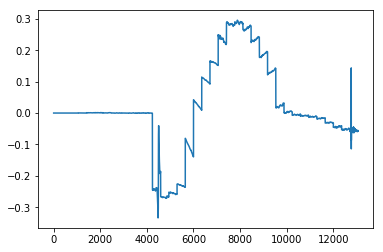

In [55]:
import matplotlib.pyplot as plt
plt.plot(z)
plt.show()

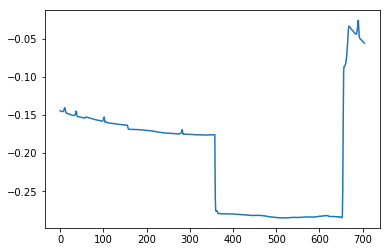

In [48]:
import matplotlib.pyplot as plt
plt.plot(delay_buf)
plt.show()

In [16]:
import pyaudio
import numpy as np

CHUNK = 4096 # number of data points to read at a time
fs = 44100 # time resolution of the recording device (Hz)

p=pyaudio.PyAudio() # start the PyAudio class
stream=p.open(format=pyaudio.paInt16,channels=1,rate=fs,input=True,
              frames_per_buffer=CHUNK) #uses default input device

# create a numpy array holding a single read of audio data
for i in range(10): #to it a few times just to see
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    print(data.shape)

# close the stream gracefully
stream.stop_stream()
stream.close()
p.terminate()

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


In [37]:
def speedx(sound_array, factor):
    """ Multiplies the sound's speed by some `factor` """
    indices = np.round( np.arange(0, len(sound_array), factor) )
    indices = indices[indices < len(sound_array)].astype(int)
    return sound_array[ indices.astype(int) ]

In [52]:
def stretch(sound_array, f, window_size, h):
    """ Stretches the sound by a factor `f` """

    phase  = np.zeros(window_size)
    hanning_window = np.hanning(window_size)
    result = np.zeros( int(len(sound_array) /f + window_size))

    for i in np.arange(0, len(sound_array)-(window_size+h), h*f):
        i = int(i)
        # two potentially overlapping subarrays
        a1 = sound_array[i: i + window_size]
        a2 = sound_array[i + h: i + window_size + h]

        # resynchronize the second array on the first
        s1 =  np.fft.fft(hanning_window * a1)
        s2 =  np.fft.fft(hanning_window * a2)
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.fft.ifft(np.abs(s2)*np.exp(1j*phase))

        # add to result
        i2 = int(i/f)
        result[i2 : i2 + window_size] += hanning_window*a2_rephased.astype(float)

    result = ((2**(16-4)) * result/result.max()) # normalize (16bit)

    return result.astype('int16')

In [43]:
def pitchshift(snd_array, n, window_size=2**13, h=2**11):
    """ Changes the pitch of a sound by ``n`` semitones. """
    factor = 2**(1.0 * n / 12.0)
    stretched = stretch(snd_array, 1.0/factor, window_size, h)
    return speedx(stretched[window_size:], factor)

C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


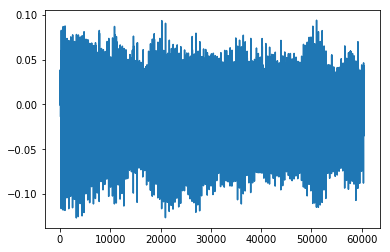

In [71]:
import librosa
data, fs = librosa.load("a.wav",sr=None)
data5 = pitchshift(data,5)

plt.plot(data)
plt.show()
data = data/max(data)
data5 = data5/max(data5)

data = data5
data = 0.3*(data/max(data))
p = pyaudio.PyAudio()
stream = p.open(format = pyaudio.paFloat32, channels = 1, rate = fs, output = True)
stream.write(data.astype(np.float32).tostring())